<a href="https://colab.research.google.com/drive/1bIxUqhrc1fHLgAgoOoaUoEgGvbhbTXqp#scrollTo=HOSMrsbTx8x0" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision tree & Random forest

## 1. Load dataset & import library

In [1]:
!gdown --folder https://drive.google.com/drive/folders/1FDfaBhqWEWhNKH0BX1S00_SU0CIZuvNj?usp=drive_link

Retrieving folder contents
Processing file 1CypV5NYf-l7CH6eovK-1rjOGNbqh8jEL X_test.csv
Processing file 1naM47Yz7se4z2161vHOGlsRPw0gZeLKd X_train.csv
Processing file 1GLNbaP-P-pDncjrz2UXT9IpH9k40Ht5G y_test.csv
Processing file 1DY3xGU4rcojDZGgNumddKqfLwgnBWJ1s y_train.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1CypV5NYf-l7CH6eovK-1rjOGNbqh8jEL
To: /content/dataset_ML/X_test.csv
100% 34.0M/34.0M [00:00<00:00, 79.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1naM47Yz7se4z2161vHOGlsRPw0gZeLKd
From (redirected): https://drive.google.com/uc?id=1naM47Yz7se4z2161vHOGlsRPw0gZeLKd&confirm=t&uuid=81f38475-2efe-4190-a4a2-4fc264e78e7f
To: /content/dataset_ML/X_train.csv
100% 136M/136M [00:01<00:00, 76.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GLNbaP-P-pDncjrz2UXT9IpH9k40Ht5G
To: /content/dataset_ML/y_test.csv
100% 4.00k/4.00k [00:00<00:00, 

In [2]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import scipy

## 2. Load train/test data from CSV file

In [3]:
X_train = pd.read_csv('./dataset_ML/X_train.csv', header=None).values
y_train = pd.read_csv('./dataset_ML/y_train.csv', header=None).values
X_test = pd.read_csv('./dataset_ML/X_test.csv', header=None).values
y_test = pd.read_csv('./dataset_ML/y_test.csv', header=None).values
print(f'X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}')

X_train.shape: (3200, 3136), X_test.shape: (800, 3136)


## 3. Classification using decision tree/ random forest


## 3.1 Decision Tree

### Source Code

In [4]:
class DecisionTreeFromScratch:
    def __init__(self):
        pass

    def find_split(self, x, y):
        """Given a dataset and its target values, this finds the optimal combination
        of feature and split point that gives the best loss function."""

        best = {'loss_fn': np.inf}
        # Loop every possible split of every dimension...
        for i in range(x.shape[1]):  # x.shape is [n,d] so x.shape[1] is d
            for split in np.unique(x[:, i]):  # unique values of each column in x
                # left indices...
                left_indices = np.where(x[:, i] <= split)
                # right indices...
                right_indices = np.where(x[:, i] > split)
                n = len(x[:, i])
                n_l = len(left_indices[0])
                n_r = len(right_indices[0])

                # calculate infogain (number of bits/nats obtained from traversing the split)...
                loss_fn = (n_l/n) * np.var(y[left_indices]) + (n_r/n) * np.var(y[right_indices])

                if loss_fn < best['loss_fn']:
                    best = {'feature': i,
                            'split': split,
                            'loss_fn': loss_fn,
                            'left_indices': left_indices[0],
                            'right_indices': right_indices[0]}
        return best


    def build_tree(self, x, y, max_depth=np.inf):
        # Check if either of the stopping conditions have been reached. If so generate a leaf node...
        # if max_depth is reached or there is only 5 left
        if max_depth == 1 or len(x) <= 5:
            # Generate a leaf node...
            mode = scipy.stats.mode(y)[0][0]
            return {'leaf': True, 'mode': mode}

        else:
            move = self.find_split(x, y)
            try:
                # recursive functions
                left = self.build_tree(x[move['left_indices'], :], y[move['left_indices']], max_depth - 1)
                right = self.build_tree(x[move['right_indices'], :], y[move['right_indices']], max_depth - 1)

                return {'leaf': False,
                        'feature': move['feature'],
                        'split': move['split'],
                        'loss_fn': move['loss_fn'],
                        'left': left,
                        'right': right}

            except KeyError:
                # when splitting does not split to left and right as keeping the original gives lowest loss fn
                mode = scipy.stats.mode(y)[0][0]
                return {'leaf': True, 'mode': mode}


    def predict(self, tree, samples):
        """Predicts class for every entry of a data matrix."""
        ret = np.empty(samples.shape[0], dtype=int)
        ret.fill(-1)
        indices = np.arange(samples.shape[0])

        def tranverse(node, indices):
            nonlocal samples
            nonlocal ret

            if node['leaf']:
                ret[indices] = node['mode']

            else:
                going_left = samples[indices, node['feature']] <= node['split']
                left_indices = indices[going_left]
                right_indices = indices[np.logical_not(going_left)]

                if left_indices.shape[0] > 0:
                    tranverse(node['left'], left_indices)

                if right_indices.shape[0] > 0:
                    tranverse(node['right'], right_indices)

        tranverse(tree, indices)
        return ret

In [5]:
clf_dt_scratch = DecisionTreeFromScratch()
tree = clf_dt_scratch.build_tree(X_train, y_train, max_depth=5)
y_pred = clf_dt_scratch.predict(tree, X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       597
         1.0       0.96      0.96      0.96       203

    accuracy                           0.98       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.98      0.98      0.98       800



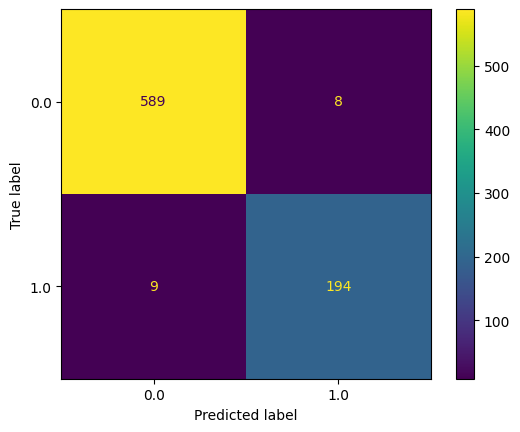

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Decision tree using scikit-learn

In [8]:
clf_dt = DecisionTreeClassifier(max_depth=3)
clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       597
         1.0       0.95      0.93      0.94       203

    accuracy                           0.97       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.97      0.97      0.97       800



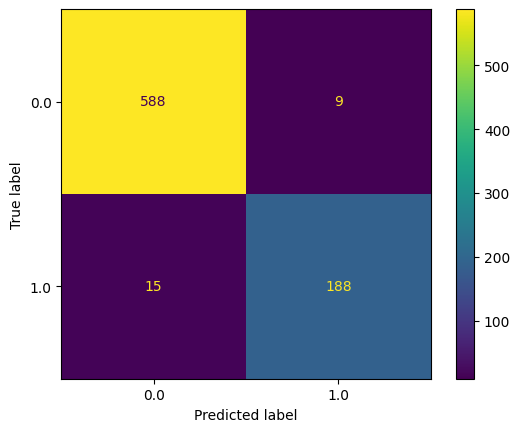

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Decision Tree Visualisation

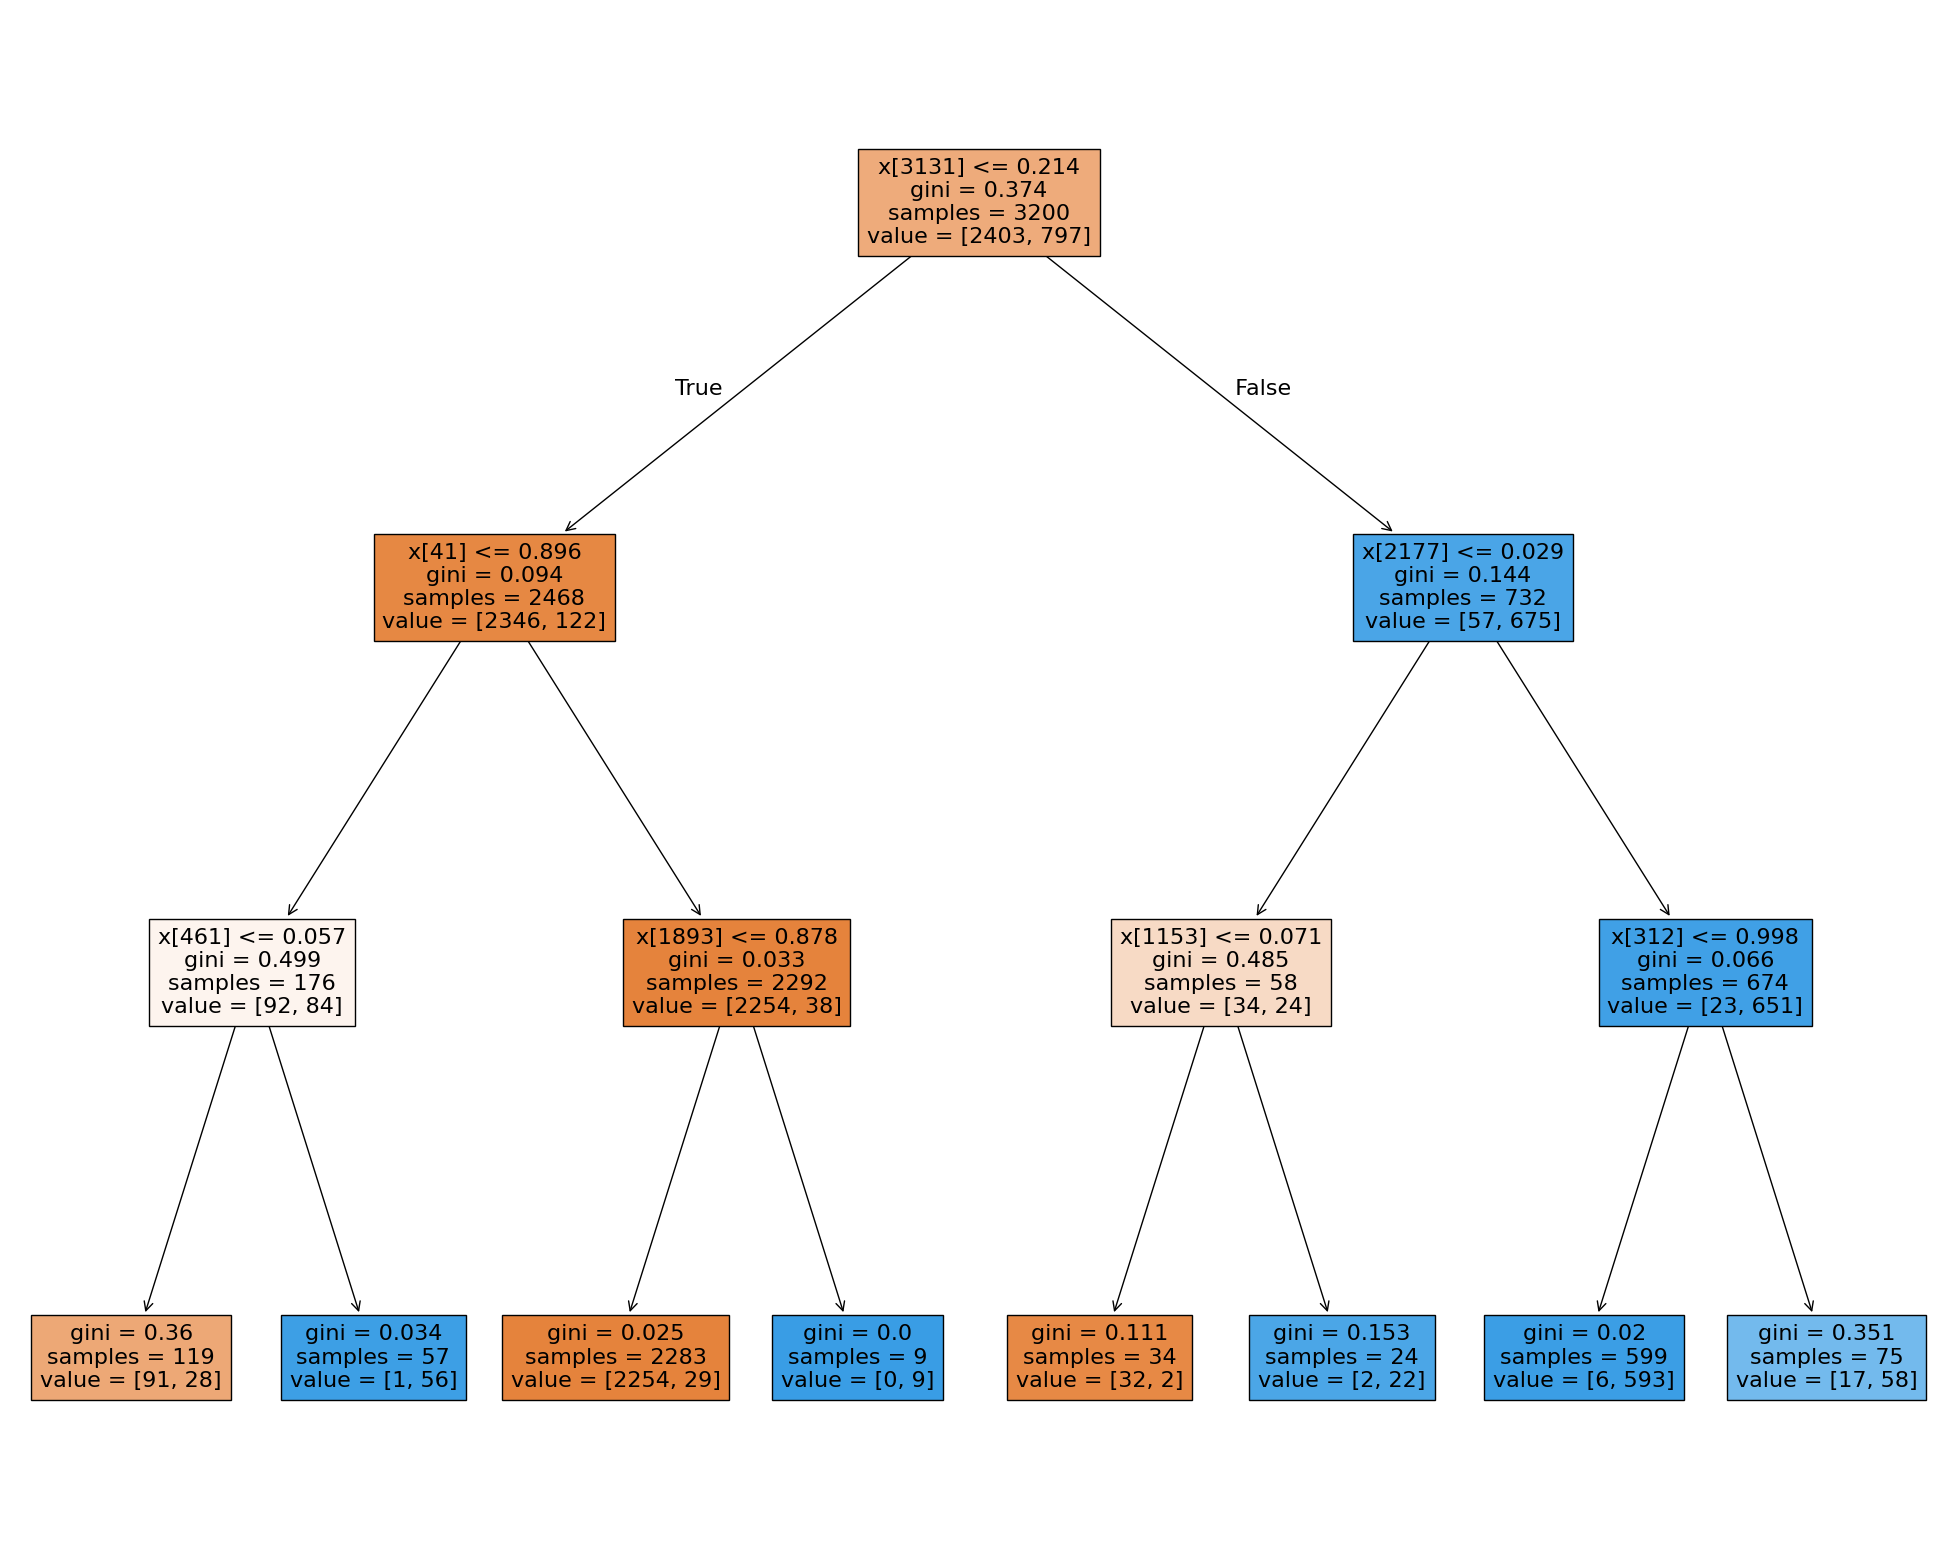

In [11]:
fig = plt.figure(figsize=(25, 20))
_ = plot_tree(clf_dt, filled=True)

## 3.2. Random Forest

### scikit-learn

In [12]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       597
         1.0       1.00      0.98      0.99       203

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



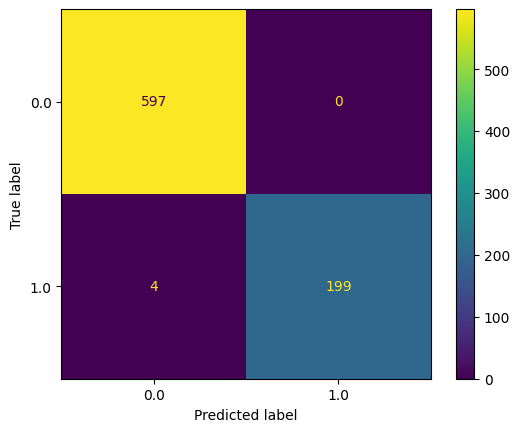

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()